In [11]:
import os
from tqdm import tqdm
import pandas as pd
import jieba

In [12]:
comment_file = 'week4.csv'

文件处理

In [13]:
def filter_file(file_path):
    df = pd.read_csv(file_path)
    save_path = 'file_group'
    # 获取shopID列的所有值，将重复的值忽略，按照升序排列成一个列表
    shop_id_list = df['shopID'].unique() #返回一个list
    year_list = df['year'].unique()
    # 将numpy.int64 object转化为普通的int类型
    shop_id_list = [int(id) for id in shop_id_list]
    year_list = [int(year) for year in year_list]
    
    for shop_id in tqdm(shop_id_list, desc = 'Processing', unit = 'shop_id'):
        # shop_all_year_dict每个键为年份，就是year_list 中的元素,值是一个列表，包含这个年份所有的评论
        shop_all_year_dict = {}
        for year in tqdm(year_list, desc = 'Processing', unit = 'year'):
            # 初始化shop_all_year_dict
            shop_all_year_dict[year] = []
            
            id_filter = df[(df['shopID']==shop_id) & (df['year']== year)]
            comments = id_filter['cus_comment']
            comments = comments.dropna()
            # 如果comments为空，继续读取下一个年份
            for comment in comments:
                if not isinstance(comment, str):
                    continue
                # 得到一个列表，是该评论行的所有词
                words = comment.split()
                shop_all_year_dict[year]+=words
                
        #将shop_all_year_dict写入文本txt,要求每个元素单独占据一行
        with open(f'{save_path}shop_{shop_id}.txt','w',encoding = 'utf-8')as file:
            # 对字典shop_all_year_dict中的每个值进行遍历
            for year_id,year_comment in shop_all_year_dict.items():
                # 将列表转化为字符串
                year_comment = ' '.join(year_comment)
                file.write(year_comment)
                file.write('\n')
            file.close() 

              
filter_file(comment_file)
        

Processing: 100%|██████████| 8/8 [00:00<00:00, 27.08shop_id/s]


In [14]:
indir_path = 'file_group'

In [15]:
stop_words = set([
    "算是","吧","在","的","不是","和","也","什么","了","人","把","就","来","不","这次","一个","没","我"
    ,"在","过","嘛","还","九","开","而","去","也","但是","都","宝宝","们","啊","但","哈","只","然后","呀"
    ,"因为","先","要","到","哈哈","同时","为了","个人感觉","上去","一边","例如"
                                                ,"一粒","次次","带我去"
                                                "哪里","其次","无法","有待","肯定","不会"
])

In [16]:
# jieba 分词
def chinese_word_cut(text):
    if not isinstance(text, str):
        return ""
    return " ".join(word for word in jieba.cut(text) if word not in stop_words)

以店铺520356为例

In [17]:
file_path='csv_filtered_group/shop_520356.txt.csv'

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import numpy as np


样本文件预清洗

In [19]:
data = pd.read_csv(file_path, encoding='utf-8')
# 处理缺失值和非字符串值
data["cus_comment"] = data["cus_comment"].fillna("").astype(str)
data["cus_comment"]=data["cus_comment"].apply(chinese_word_cut)
print("after word cut",data["cus_comment"].head())

after word cut 0    位置   好找   路边   同事   带   着   过来   打卡   按照   特色菜...
1    油   吃   多   两个   腻味   道   还是   很棒   值得   一试   ...
2    差   左烟   韧感   太软   口感   芬芳   真的   太   好吃   一  ...
3    又   一次   来到   芬芳   寻找   记忆   中   味道   百合   莲子 ...
4    豆   西米   当年   高中   必点   甜品   同福   这 间   芬芳   果...
Name: cus_comment, dtype: object


In [20]:
n_features = 30 # 提取30个特征词语
# 初始化 CountVectorizer
tf_vectorizer = CountVectorizer(
                                strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words = None,
                                max_df=0.6,# 调整为允许更高频率的词
                                min_df=5 # 调整为较低的最小出现次数
                                )

拟合并转换文本数据为词频矩阵

In [21]:
tf = tf_vectorizer.fit_transform(data["cus_comment"])
if len(tf_vectorizer.get_feature_names_out()) == 0:
        print("警告：词汇表为空，请检查参数设置或数据内容！")
else:
    print("词汇表：", tf_vectorizer.get_feature_names_out())
    print("词频矩阵：\n", tf.toarray())

词汇表： ['一共' '一如既往' '一条街' '一杯' '三家' '东路' '二楼' '位于' '出口' '地铁站' '好喝' '对于' '对面'
 '小丸子' '左个' '情怀' '整体' '柚子' '点餐' '猪肉' '紫米' '莲子' '菜单' '虾米' '蛋挞' '路上' '这边'
 '速度' '隔壁' '黑糯米']
词频矩阵：
 [[ 2  1  4  3 17  7 12  7  6  9  3  3  8 20  0  3  6  4  6  4  1  3  5  4
   6  5  8  9  5  9]
 [ 9  4  7  8 10  8 10  4  7  6  6  3  4 18  2  3  6  2  7  5 14 10  3  1
   8  3  6  4  0  2]
 [ 3  1  7  1  7  5  6  5  3  8  4  2  1  9  0  3  4  1  2  6  7  3  2  2
   4  3  4  1  0  3]
 [ 3  7  8  5 10  6  5  8 10  6  2  5  5 16  0  5  3  5  3  2  3  5  4  3
   1  9  7  3  4 13]
 [ 3  8  8  7 12  8 12  7  8  5  5  2  4 12  1  7  4  5  2  6 10  3  8  7
   2 15  1  5  3 12]
 [ 0  2  2  2  4  2  5  0  5  3  3  2  4  8  0  4  3  0  2  5  4  2  2  4
   7  8  1  1  2 10]
 [ 4  7  2  2  3  7  3  4  5  7  4  6  5 13  1  8  4  7  6  1  6  0  4  3
   4  6  2  5  4  9]
 [ 1  4  4  3  2  0  1  1  2  6  0  0  0  7  1  3  3  1  2  2  1  0  1  5
   1  1  5  0  3  4]
 [ 3  5  3  3  3  3  5  0  6  7  6  3  0  8  0  1  3  2  4  4  6  1 

无监督学习训练模型

In [22]:
n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,# 最大迭代次数
                                learning_method='batch',
                                learning_offset=50, # 学习偏移量
#                                 doc_topic_prior=0.1,
#                                 topic_word_prior=0.01,
                            random_state=0 # 随机种子，默认为0。确保每次运行结果一致
                            )

将转换后的词频矩阵进行拟合提取潜在主题

In [23]:
lda.fit(tf)

LatentDirichletAllocation(learning_offset=50, max_iter=50, n_components=8,
                          random_state=0)

In [24]:
# 打印高频词
def print_top_words(model, feature_names, n_top_words):
    # 返回列表top_words
    tword = []
    for topic_idx, topic in enumerate(model.components_):# model.components_包含每个主题对应的词分布向量，topic_idx 表示当前主题的索引
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

每个主题对应词语

In [25]:
n_top_words = n_features
tf_feature_names = tf_vectorizer.get_feature_names_out() # 长度为n_features，这里是30
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
左个 柚子 猪肉 一杯 好喝 莲子 地铁站 一共 东路 对面 情怀 隔壁 点餐 出口 整体 黑糯米 二楼 一条街 对于 这边 位于 虾米 速度 菜单 路上 三家 小丸子 一如既往 紫米 蛋挞
Topic #1:
一杯 整体 隔壁 对面 地铁站 左个 点餐 出口 黑糯米 好喝 情怀 东路 莲子 二楼 一条街 柚子 猪肉 对于 这边 位于 虾米 速度 一共 菜单 路上 三家 小丸子 一如既往 紫米 蛋挞
Topic #2:
黑糯米 路上 一如既往 紫米 小丸子 出口 菜单 地铁站 二楼 情怀 好喝 虾米 一条街 一杯 柚子 猪肉 东路 对于 一共 点餐 三家 隔壁 整体 速度 蛋挞 莲子 左个 对面 位于 这边
Topic #3:
隔壁 点餐 虾米 三家 紫米 东路 柚子 对面 二楼 整体 情怀 菜单 一如既往 好喝 路上 一条街 这边 一杯 左个 地铁站 出口 黑糯米 莲子 猪肉 对于 位于 速度 一共 小丸子 蛋挞
Topic #4:
紫米 一共 二楼 莲子 一条街 出口 好喝 一杯 一如既往 位于 黑糯米 猪肉 左个 点餐 蛋挞 整体 对于 东路 地铁站 小丸子 菜单 这边 三家 情怀 速度 虾米 路上 柚子 对面 隔壁
Topic #5:
小丸子 三家 地铁站 二楼 位于 东路 这边 蛋挞 对面 整体 黑糯米 速度 一条街 点餐 出口 路上 猪肉 情怀 莲子 菜单 一杯 对于 柚子 虾米 隔壁 好喝 一共 一如既往 紫米 左个
Topic #6:
左个 隔壁 这边 对于 虾米 速度 莲子 整体 小丸子 地铁站 黑糯米 位于 出口 二楼 一条街 一杯 猪肉 一如既往 紫米 情怀 东路 一共 点餐 对面 蛋挞 柚子 三家 菜单 路上 好喝
Topic #7:
左个 猪肉 对面 对于 一共 速度 莲子 这边 东路 三家 一条街 路上 点餐 菜单 地铁站 二楼 柚子 整体 一杯 一如既往 蛋挞 小丸子 好喝 紫米 出口 情怀 位于 虾米 黑糯米 隔壁


输出每篇文章对应主题

In [26]:
topics=lda.transform(tf) # 返回每个文档在各个主题上的概率分布
topic = []
for t in topics:
    topic.append(list(t).index(np.max(t))) # 遍历每个文档的主题分布，找到最大值对应的索引（即最相关的主题编号）
data['topic']=topic # 添加主题列并保存数据
data.to_csv("/Users/wtsama/Documents/code/code2/python_assignment/week4/shop_520356_topic.csv",index=False)
topics[0]#0 1 2 查看第一个文档的主题编号

array([6.91223722e-04, 6.90770904e-04, 6.91949861e-04, 6.91773743e-04,
       6.91838978e-04, 9.95159310e-01, 6.91655263e-04, 6.91477871e-04])

文档-主题分布可视化

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
def plot_document_topic_distribution(topics, n_topics):
    # 设置中文字体（支持中文且系统自带）
    #font_path ='/System/Library/AssetsV2/com_apple_MobileAsset_Font7/c3a843d226791256d897018e02e6c09b1ef283a9.asset/AssetData/Kavivanar-regular.ttf'
    #font = fm.FontProperties(fname=font_path)
    #plt.rcParams['font.family'] = font.get_name()
    #plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
    #plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Microsoft YaHei', 'SimHei']
    #plt.rcParams['axes.unicode_minus'] = False

    plt.figure(figsize=(12, 8))
    sns.heatmap(topics, cmap="YlGnBu", xticklabels=[f'Topic{i}' for i in range(n_topics)])
    plt.title("Document-Topic Distribution")
    plt.xlabel("Topic")
    plt.ylabel("Document")
    plt.show()

调用函数绘制文档-主题分布

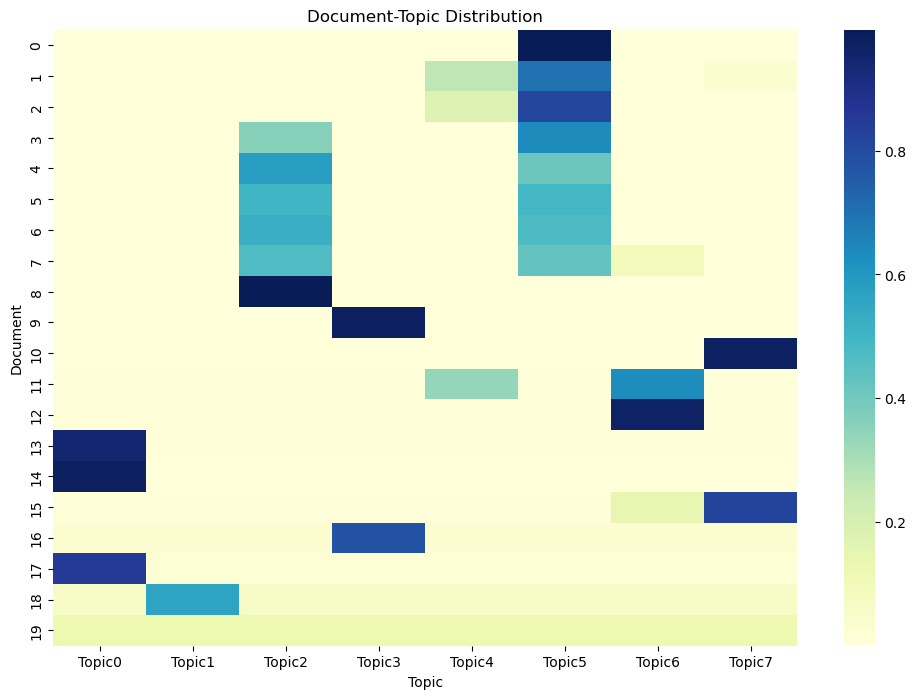

In [29]:
plot_document_topic_distribution(topics, n_topics)

利用pickle或json对所得到的lda模型、对应的词频矩阵、以及特征表示等进行序列化保存

In [30]:
import pickle

In [31]:
# 保存前将所有对象存入字典
save_data = {
    'lda_model': lda,
    'tf_matrix': tf,
    'vectorizer': tf_vectorizer,
    'topic_words': topic_word,
    'topic_list': topic
}
# 一次性保存，并修改保存路径
file_name = 'lda_model'
with open(file_name + '.pkl', 'wb') as f:
    pickle.dump(save_data, f)
print('保存成功')

保存成功


困惑度分析

In [32]:
import matplotlib.pyplot as plt

In [33]:
plexs = []
n_max_topics = 100
for i in range(1,n_max_topics):
    # print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))

save plex pic successfully


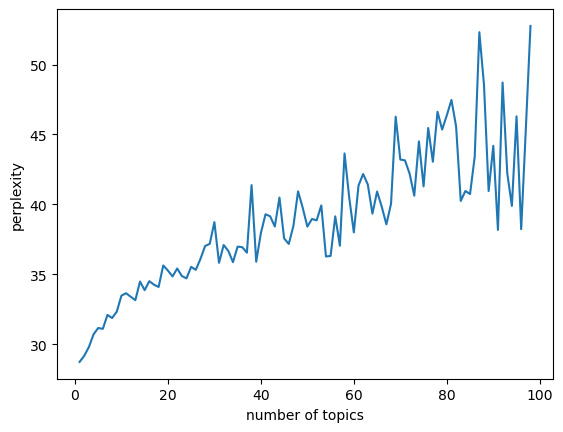

In [34]:
n_t=99 # 区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,plexs[1:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
# 存储图片
save_plex_pic_path = '/Users/wtsama/Documents/code/code2/python_assignment/week4/pic/'
file_name = 'plex_pic.png'

plt.savefig(f'{save_plex_pic_path}{file_name}_with_'+str(n_max_topics)+'topics'+'.png')
print('save plex pic successfully')

plt.show()